# Running `fftvis`

In this notebook, we'll give a brief demonstration of how to use `fftvis` to simulate visibilities for a set of input simulation parameters. This tutorial is very similar to the one included in the `matvis` simulator package. One should consolunt that tutorial for a difference in the use cases of `fftvis` and `matvis`.

<div class="alert alert-info">

__Note__

The absolute easiest way to use `fftvis` is via the `hera_sim` [plugin interface](https://hera-sim.readthedocs.io/en/latest/tutorials/hera_sim_vis_cli.html).
</div>

<div class="alert alert-warning">

__Warning__

Before running this tutorial, you should make sure you understand the basic concepts and algorithm that `fftvis` uses. You can read up on that here.
</div>

In [1]:
# Standard imports
import numpy as np
import healpy as hp
from astropy.time import Time
import matplotlib.pyplot as plt

# HERA-stack imports
import fftvis
import matvis
from hera_sim.antpos import hex_array
from pyuvdata.telescopes import Telescope
from pyuvdata.analytic_beam import AiryBeam

/opt/anaconda3/envs/matvis-env/lib/python3.11/site-packages/pyuvdata/analytic_beam.py:111: UserWarning: basis_vector_type was not defined, defaulting to azimuth and zenith_angle.
  warnings.warn(


## Setup Telescope / Observation Parameters

We need a few input parameters to setup our observation: antenna positions, beam models, and a sky model.

Here we will set up a very simple observation for introductory purposes.

First, create our antenna positions. We define this as a dictionary, which maps an antenna number to its 3D East-North-Up position relative to the array centre. Here, we define just a hexagonal array of 15 antennas using `hera_sim.antpos.hex_array`.

In [2]:
# define antenna array positions
antpos = hex_array(3, split_core=True, outriggers=0)

Next, we define the beam to be used by all antennas in the array. Unlike `matvis` and `pyuvsim`, `fftvis` currently restricts users to a single beam for all antennas. The specified beam must be a `UVBeam` or `AnalyticBeam` object from `pyuvdata`. Alternatively, you can create a custom `AnalyticBeam` class (see the pyuvdata tutorial on `UVBeam` objects for guidance). For this simulation, we will use a simple, frequency-dependent Airy beam corresponding to a dish size of 14 meters.

In [3]:
# define antenna beam using pyuvdata.analytic_beam.AiryBeam with a dish size of 14 meters
beam = AiryBeam(diameter=14.0)

We also required to provide `fftvis` with the observational configuration including a frequency array, a time array, and a telescope location. The frequency array specifies the observation frequencies in units of Hz. The time array defines the observation times using an `astropy.time.Time` object, with times specified in Julian Dates and configured with the appropriate format and scale. The telescope location specifies the geographic position of the array and can be defined either using `astropy.coordinates.EarthLocation` with a known site name or through `pyuvdata.telescopes.Telescope` by selecting a predefined telescope location supported within `pyuvdata`.

In [4]:
# define a list of frequencies in units of Hz
nfreqs = 20
freqs = np.linspace(100e6, 120e6, nfreqs)

In [5]:
# define a list of times with an astropy time.Time object
ntimes = 30
times = Time(np.linspace(2459845, 2459845.05, ntimes), format='jd', scale='utc')

In [6]:
from astropy.coordinates import EarthLocation

# define using astropy.coordinates.EarthLocation
telescope_loc = EarthLocation.of_site('meerkat')

# define the telescope location using the pyuvdata.telescopes.Telescope
telescope_loc = Telescope.from_known_telescopes('hera').location

## Setup Sky Model

Like `matvis`, `fftvis` makes the point source approximation -- that is it makes breaks a continuous sky model into a discrete number of point sources that it sums over when computing the visibilities. In this notebook, we'll assume the point source approximation by discretizing the sky with a randomly generated HEALpix map.

In [7]:
# number of sources
nside = 64
nsource = hp.nside2npix(nside)

# pixels can be defined as point sources randomly distributed over the full sky
ra = np.deg2rad(np.random.uniform(0, 360, nsource))        # ra of each source (in rad)
dec = np.deg2rad(np.random.uniform(-90, 90.0, nsource))    # dec of each source (in rad)

# define sky model using healpix map
dec, ra = hp.pix2ang(nside, np.arange(nsource))
dec -= np.pi / 2

# define the flux of the sources as a function of frequency. Here, we define smooth spectrum sources
flux = np.random.uniform(0, 1, nsource)                              # flux of each source at 100MHz (in Jy)
alpha = np.ones(nsource) * -0.8                      # sp. index of each source

# Now get the (Nsource, Nfreq) array of the flux of each source at each frequency.
flux_allfreq = ((freqs[:, np.newaxis] / freqs[0]) ** alpha.T * flux.T).T

## Run `fftvis` in single processor mode

Now that we've setup all our parameters, we can easily run the simulation using the high-level wrapper API. Along with the configuration we've already defined, the `fftvis.simulate.simulate_vis` wrapper takes a few extra options. One of the most important is `polarized`: if true, then full polarized visibilities are returned (with shape `(nfreqs, ntimes, nfeed, nfeed, nbls)`), otherwise, unpolarized visibilities are returned (with shape (nfreqs, ntimes, nants, nants)). In our case, the `AnalyticBeam` objects we're using don't support polarization, so we set this to false.

We can also set the `precision` parameter, which switches between 32-bit (if `precision=1`) and 64-bit (if `precision=2`) floating precision. In addition to controlling the floating point precision, the `fftvis` also includes a parameter `eps` which can improve the precision of the underlying Non-Uniform FFT. The runtime of the simulation is roughly inversely proportional to the `eps` parameter for a set `precision` value.

In [8]:
# Define subset of baselines we're interested in for simulating
baselines = [(i, j) for i in range(len(antpos)) for j in range(len(antpos))]

In [9]:
%%time
# simulate visibilities with the new API
vis_vc = fftvis.simulate_vis(
    ants=antpos,
    fluxes=flux_allfreq,
    ra=ra,
    dec=dec,
    freqs=freqs,
    times=times.jd,
    telescope_loc=telescope_loc,
    beam=beam,
    polarized=False,
    precision=2,
    nprocesses=1,
    baselines=baselines,
    backend="cpu"  # Explicitly specify the backend (new parameter)
)

CPU times: user 4.17 s, sys: 1.42 s, total: 5.59 s
Wall time: 3.35 s


In [10]:
%%time
# simulate visibilities 
vis_vc_matvis = matvis.simulate_vis(
    ants=antpos,
    fluxes=flux_allfreq,
    ra=ra,
    dec=dec,
    freqs=freqs,
    times=times,
    telescope_loc=telescope_loc,
    beams=[beam],
    polarized=False, # flag on whether to use a polarized beam model
    precision=2,
)

CPU times: user 18.1 s, sys: 1.42 s, total: 19.6 s
Wall time: 19.6 s


In [11]:
np.allclose(vis_vc, vis_vc_matvis)

True

## Run `fftvis` in parallel processing mode

`fftvis` also includes the option to run in multiprocessing mode to more efficiently make use of multiple processors on a machine. `fftvis` parallelizes the computation by sending chunks of times and frequencies to separate processers using the multiprocessing library `ray` which the handles the distribution and memory management of variables shared across independent processes. Running in parallel processing mode does slightly increase the memory usage of `fftvis.simulate.simulate_vis`, but large arrays such as the point source model are shared across processes. Here, we run the same simulation as above, but use the `nprocesses` command to increase the number of independent processes. Since, `ray` has some overhead, the simulation isn't `nprocesses` faster in this case, but should be close when the simulation runtime is significantly longer than the `ray` overhead time.

In [12]:
%%time
# First run is slow, to set up ray multiprocessing
_ = fftvis.simulate_vis(
    ants=antpos,
    fluxes=flux_allfreq,
    ra=ra,
    dec=dec,
    freqs=freqs,
    times=times.jd,
    telescope_loc=telescope_loc,
    beam=beam,
    polarized=False,
    precision=2,
    trace_mem=False, 
    nprocesses=6, 
    backend="cpu"
)

2025-05-06 10:47:30,601	INFO worker.py:1821 -- Started a local Ray instance.


CPU times: user 94.9 ms, sys: 162 ms, total: 256 ms
Wall time: 6.67 s


In [13]:
%%time
# Second run is faster since ray instances are already produced
vis_vc = fftvis.simulate_vis(
    ants=antpos,
    fluxes=flux_allfreq,
    ra=ra,
    dec=dec,
    freqs=freqs,
    times=times.jd,
    telescope_loc=telescope_loc,
    beam=beam,
    polarized=False,
    precision=2,
    trace_mem=False, 
    nprocesses=6, 
    backend="cpu"  
)

# Shut down Ray after completion to prevent background warnings
import ray
ray.shutdown()

CPU times: user 30 ms, sys: 26.8 ms, total: 56.8 ms
Wall time: 2.15 s


## Plot auto and cross visibilities

Here, we plot the visibility amplitude and phase as a function of frequency and LSTs. For auto-correlation (e.g. antenna pair (0,0)) we expect the phase would be zero. Here, the amplitude is constant with frequency as we assumed the spectral of the sources are zero.

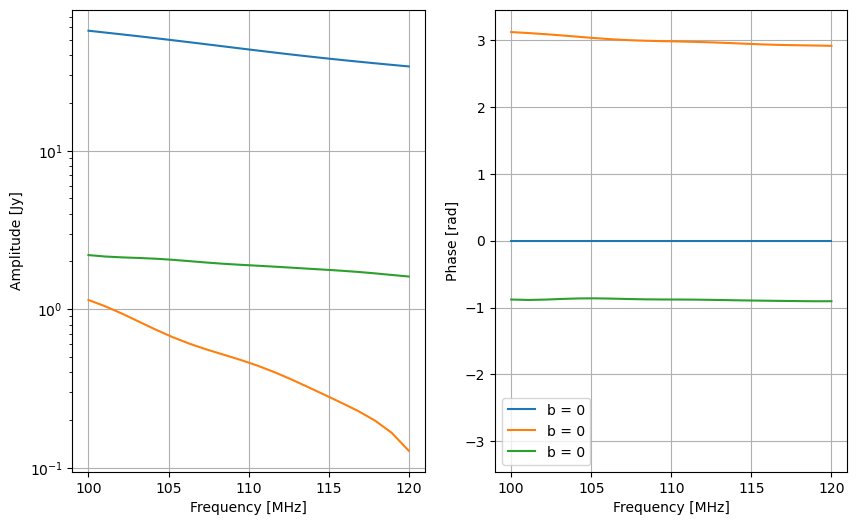

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for bl_index, bl in enumerate(baselines[:3]):
    axs[0].semilogy(freqs / 1e6, np.abs(vis_vc[:, 0, bl_index]))
    axs[1].plot(freqs / 1e6, np.angle(vis_vc[:, 0, bl_index]), label=f"b = {bl[0]}")

axs[1].legend()
axs[0].set_xlabel('Frequency [MHz]')
axs[1].set_xlabel('Frequency [MHz]')
axs[0].set_ylabel('Amplitude [Jy]')
axs[1].set_ylabel('Phase [rad]')
axs[1].set_ylim(-np.pi * 1.1, np.pi * 1.1)
axs[0].grid()
axs[1].grid()
plt.show()

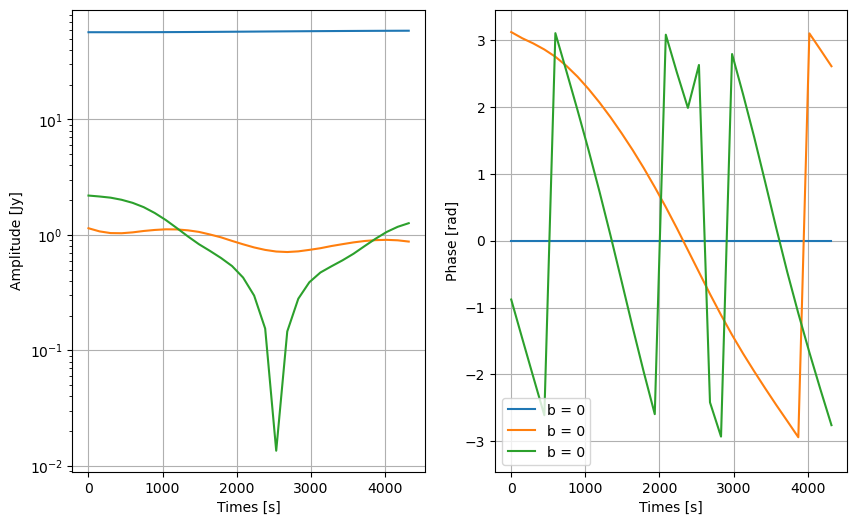

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
for bl_index, bl in enumerate(baselines[:3]):
    axs[0].semilogy(times.unix - times.unix[0], np.abs(vis_vc[0, :, bl_index]))
    axs[1].plot(times.unix - times.unix[0], np.angle(vis_vc[0, :, bl_index]), label=f"b = {bl[0]}")

axs[0].set_xlabel('Times [s]')
axs[1].set_xlabel('Times [s]')
axs[0].set_ylabel('Amplitude [Jy]')
axs[1].set_ylabel('Phase [rad]')
axs[1].set_ylim(-np.pi * 1.1, np.pi * 1.1)
axs[0].grid()
axs[1].grid()
plt.legend()
plt.show()